<a href="https://colab.research.google.com/github/Skevrek/MBA_Thesis/blob/main/RandomForest_Semis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.express as px
import statistics
from scipy import stats
from sklearn.metrics import r2_score
from google.colab import data_table
from sklearn.model_selection import GridSearchCV
data_table.enable_dataframe_formatter()

In [2]:
df = pd.read_excel("/content/drive/MyDrive/MBA/DataTables_Semis-Forecasting/DataTable_Semis-Forecasting-1M.xlsx")

In [3]:
df.head(5)

,Date,PPI,PPI_Lagged,GPR,Export_Semis,Import_Semis,Employees_Semis,Export_NoSemis,Import_NoSemis,RIW_Semis,Export_CapitalGoods,IP_NoEnergy
0,1994-01-01,4.656813,4.656813,4.376408,4.952300,5.087596,6.256134,5.144583,4.676560,1.047985,4.570579,4.560595
1,1994-02-01,4.657763,4.656813,4.424727,4.950177,5.083886,6.258242,5.130490,4.678421,1.072884,4.572647,4.558226
2,1994-03-01,4.657763,4.657763,4.764241,4.957938,5.075799,6.260537,5.121580,4.677491,1.084209,4.572647,4.557494
3,1994-04-01,4.658711,4.657763,4.537684,4.955827,5.085743,6.264731,5.117994,4.682131,1.110640,4.572647,4.570966
4,1994-05-01,4.657763,4.658711,4.557627,4.938065,5.084505,6.269854,5.114995,4.683981,1.147783,4.571613,4.575610


In [4]:
df.columns

Index(['Date', 'PPI', 'PPI_Lagged', 'GPR', 'Export_Semis', 'Import_Semis',
       'Employees_Semis', 'Export_NoSemis', 'Import_NoSemis', 'RIW_Semis',
       'Export_CapitalGoods', 'IP_NoEnergy'],
      dtype='object')

<ipython-input-5-af785ddfd842>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['PPI'].drop('PPI').sort_values().plot(kind='bar')


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Export_CapitalGoods'),
  Text(1, 0, 'Import_NoSemis'),
  Text(2, 0, 'GPR'),
  Text(3, 0, 'IP_NoEnergy'),
  Text(4, 0, 'Employees_Semis'),
  Text(5, 0, 'RIW_Semis'),
  Text(6, 0, 'Export_Semis'),
  Text(7, 0, 'Import_Semis'),
  Text(8, 0, 'Export_NoSemis'),
  Text(9, 0, 'PPI_Lagged')])

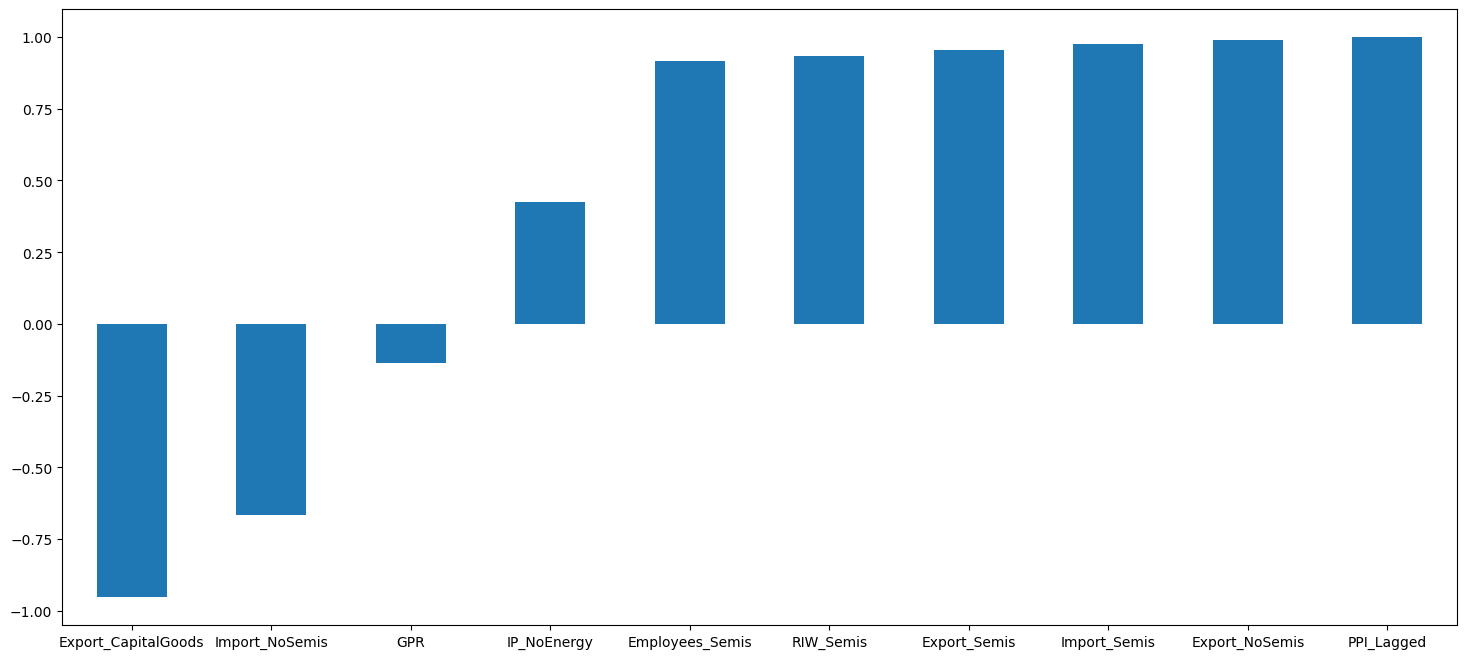

In [5]:
plt.figure(figsize=(18,8))
df.corr()['PPI'].drop('PPI').sort_values().plot(kind='bar')
plt.xticks(rotation='horizontal')

**Forecasting for 1 month**

In [6]:
cdf_1M = df[['PPI', 'PPI_Lagged']]
cdf_1M.tail(5)

,PPI,PPI_Lagged
344,4.039924,4.036574
345,4.048527,4.039924
346,4.052446,4.048527
347,4.053141,4.052446
348,4.045749,4.053141


In [7]:

# Split the data into a % training set and % test set
train_size = 0.7
train_idx = int(train_size * len(cdf_1M))
train_data = cdf_1M.iloc[:train_idx]
test_data = cdf_1M.iloc[train_idx:]

# Split the training and test data into features and target variables
X_train = train_data.drop(columns=['PPI']).values
y_train = train_data['PPI'].values
X_test = test_data.drop(columns=['PPI']).values
y_test = test_data['PPI'].values

In [8]:
X_test

array([[4.07243973],
       [4.07243973],
       [4.07243973],
       [4.07414185],
       [4.07243973],
       [4.07414185],
       [4.07414185],
       [4.07243973],
       [4.07243973],
       [4.07243973],
       [4.07243973],
       [4.0707347 ],
       [4.0707347 ],
       [4.07243973],
       [4.06560209],
       [4.06731589],
       [4.06388535],
       [4.06216566],
       [4.06216566],
       [4.06216566],
       [4.06044301],
       [4.05525717],
       [4.05352257],
       [4.05352257],
       [4.05178495],
       [4.05178495],
       [4.05178495],
       [4.0500443 ],
       [4.0500443 ],
       [4.04480412],
       [4.04129534],
       [4.04129534],
       [4.04129534],
       [4.0500443 ],
       [4.04830062],
       [4.04830062],
       [4.05352257],
       [4.05178495],
       [4.0500443 ],
       [4.03600899],
       [4.03246916],
       [4.02535169],
       [4.02535169],
       [4.02535169],
       [4.02535169],
       [4.02713581],
       [4.03069454],
       [4.030

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize best R2 score to a very small value
best_r2_score = -float('inf')
best_y_pred = -float('inf')
# Try different values of n_estimators
n_estimators_list = [10, 50, 100, 200, 500]

# Train random forest regression model
for n_estimators in n_estimators_list:
  rf = RandomForestRegressor(n_estimators=n_estimators,random_state=42)
  rf.fit(X_train, y_train)
  # Make predictions on test set
  y_pred = rf.predict(X_test)

  # Calculate evaluation metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Check if current R2 score is better than the best so far
  if r2 > best_r2_score:
      best_r2_score = r2
      best_mae = mae
      best_mse = mse
      best_n_estimators = n_estimators
      best_y_pred = y_pred

  # Print evaluation metrics
  print(f'Random Forest with {n_estimators} estimators')
  print('Random Forest MAE:', mae)
  print('Random Forest MSE:', mse)
  print('Random Forest R2 score:', r2)
  print('\n')


# Print the results with the best R2 score
print(f'Best Random Forest with {best_n_estimators} estimators')
print('Random Forest MAE:',  best_mae)
print('Random Forest MSE:',  best_mse)
print('Random Forest R2 score:', best_r2_score)

rf = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)
rf.fit(X_train, y_train)

Random Forest with 10 estimators
Random Forest MAE: 0.042950903005716544
Random Forest MSE: 0.0024692195959766234
Random Forest R2 score: -2.9842271660782265


Random Forest with 50 estimators
Random Forest MAE: 0.04363836295295226
Random Forest MSE: 0.0025303422821451034
Random Forest R2 score: -3.0828521191172094


Random Forest with 100 estimators
Random Forest MAE: 0.04419261649923537
Random Forest MSE: 0.002580543851957431
Random Forest R2 score: -3.1638552257473185


Random Forest with 200 estimators
Random Forest MAE: 0.044219125906092144
Random Forest MSE: 0.002582833690788062
Random Forest R2 score: -3.1675500117800413


Random Forest with 500 estimators
Random Forest MAE: 0.04426617074688289
Random Forest MSE: 0.0025869728760925096
Random Forest R2 score: -3.1742288242122303


Best Random Forest with 10 estimators
Random Forest MAE: 0.042950903005716544
Random Forest MSE: 0.0024692195959766234
Random Forest R2 score: -2.9842271660782265


RandomForestRegressor(n_estimators=10, random_state=42)

In [10]:
y_train

array([4.65681342, 4.65776264, 4.65776264, 4.65871095, 4.65776264,
       4.65871095, 4.65776264, 4.65109912, 4.64631213, 4.64053733,
       4.63957161, 4.63763738, 4.63569939, 4.64053733, 4.63278535,
       4.63375764, 4.63181212, 4.6298628 , 4.62595273, 4.62497281,
       4.62595273, 4.62790967, 4.62790967, 4.62693168, 4.62497281,
       4.6230101 , 4.61115226, 4.60216568, 4.59612944, 4.59208495,
       4.59208495, 4.59208495, 4.5930976 , 4.58496748, 4.58292458,
       4.58292458, 4.57677071, 4.57057874, 4.57057874, 4.56642936,
       4.55807858, 4.55912625, 4.55912625, 4.54542018, 4.54542018,
       4.53903038, 4.53582011, 4.53582011, 4.53152365, 4.52828914,
       4.52720864, 4.52612698, 4.52287494, 4.52178858, 4.51852238,
       4.51633897, 4.51415079, 4.5130549 , 4.51085951, 4.51085951,
       4.50865929, 4.50755736, 4.50755736, 4.50534985, 4.50424427,
       4.49869794, 4.49647077, 4.49869794, 4.49980967, 4.49647077,
       4.49423863, 4.49200149, 4.48638665, 4.48413186, 4.48413

In [11]:
train_y_pred = rf.predict(X_train)
train_mape = np.mean(np.abs((y_train - train_y_pred) / y_train)) * 100
print("Train MAPE: {:.8f}%".format(train_mape))

# test_mape = np.mean(np.abs((result_df['true'] - result_df['svr_predicted']) / result_df['true'])) * 100
test_mape = np.mean(np.abs((y_test-best_y_pred) / y_test)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.05475490%
Test MAPE: 1.06882712%


In [12]:
train_actual = train_data.reset_index(drop=True)
train_pred = pd.DataFrame(rf.predict(X_train), columns=['PPI_pred'])

# Create dataframes for actual and predicted values of test set
test_actual = test_data.reset_index(drop=True)
test_pred = pd.DataFrame(best_y_pred, columns=['PPI_pred'])

# Concatenate actual and predicted values for train and test sets
train_df = pd.concat([train_actual, train_pred], axis=1)
test_df = pd.concat([test_actual, test_pred], axis=1)

# Calculate MAPE for train and test sets separately
train_df['MAPE'] = np.abs(train_df['PPI'] - train_df['PPI_pred']) / train_df['PPI']
test_df['MAPE'] = np.abs(test_df['PPI'] - test_df['PPI_pred']) / test_df['PPI']

# Print train and test MAPE results
print("Train MAPE: {:.8%}".format(train_df['MAPE'].mean()))
print("Test MAPE: {:.8%}".format(test_df['MAPE'].mean()))

Train MAPE: 0.05475490%
Test MAPE: 1.06882712%


In [13]:
test_df

,PPI,PPI_Lagged,PPI_pred,MAPE
0,4.072440,4.072440,4.076097,0.000898
1,4.072440,4.072440,4.076097,0.000898
2,4.074142,4.072440,4.076097,0.000480
3,4.072440,4.074142,4.073976,0.000377
4,4.074142,4.072440,4.076097,0.000480
...,...,...,...,...
100,4.039924,4.036574,4.076097,0.008954
101,4.048527,4.039924,4.076097,0.006810
102,4.052446,4.048527,4.076097,0.005836
103,4.053141,4.052446,4.076097,0.005664


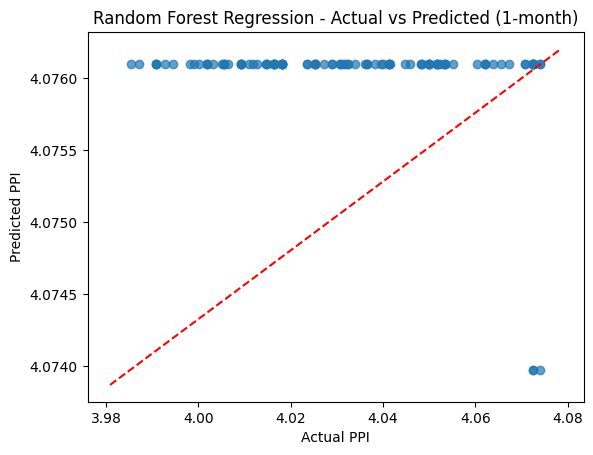

In [14]:
import matplotlib.pyplot as plt

# Scatter plot of predicted vs actual values
plt.scatter(y_test, best_y_pred, alpha=0.7)
plt.title(f'Random Forest Regression - Actual vs Predicted (1-month)')
plt.xlabel('Actual PPI')
plt.ylabel('Predicted PPI')
x_line = plt.xlim()
y_line = plt.ylim()
plt.plot(x_line, y_line, color='red', linestyle='--')
plt.show()

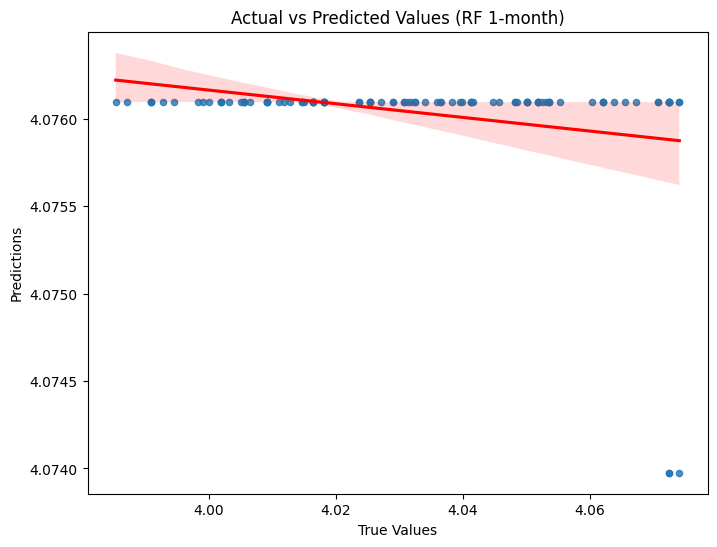

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot actual vs predicted values
sns.regplot(x=y_test, y=best_y_pred, scatter_kws={"s": 20}, line_kws={"color": "red"})
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Actual vs Predicted Values (RF 1-month)")
plt.show()

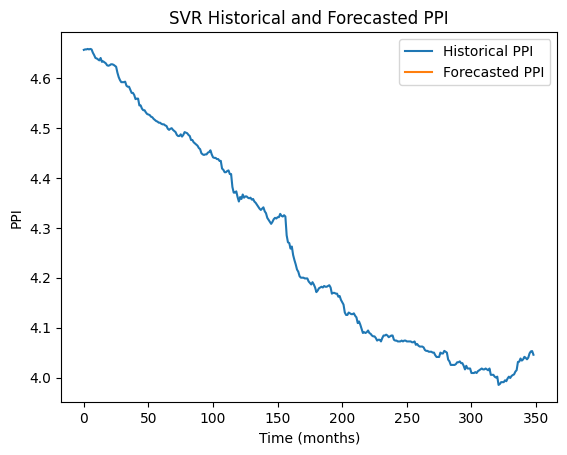

Forecasted PPI for the next month: 4.076096510249885


In [16]:
# define the predictor variables for the forecast
X_pred = cdf_1M[['PPI_Lagged']].iloc[-1].values.reshape(1, -1)

# predict the target variable for the next month
y_pred = rf.predict(X_pred)

# create a new DataFrame for the predicted values
forecast_df = pd.DataFrame(data=y_pred, columns=['PPI'])

# set the index to the next month
forecast_df = pd.DataFrame({'Forecasted PPI': y_pred}, index=[pd.date_range(start=cdf_1M.index[-1], periods=2, freq='MS')[1]])

# plot the actual and forecasted values
plt.plot(range(len(cdf_1M)), cdf_1M['PPI'], label='Historical PPI')
plt.plot(range(len(cdf_1M),len(cdf_1M)+1), forecast_df['Forecasted PPI'], label='Forecasted PPI')
plt.xlabel('Time (months)')
plt.ylabel('PPI')
plt.title('SVR Historical and Forecasted PPI')
plt.legend()
plt.show()
print("Forecasted PPI for the next month:", y_pred[0])

**Forecasting for 3 month(s)**

In [17]:
df = pd.read_excel("/content/drive/MyDrive/MBA/DataTables_Semis-Forecasting/DataTable_Semis-Forecasting-3M.xlsx")

In [18]:
df.tail(5)

,Date,PPI,PPI_Lagged,GPR,Export_Semis,Import_Semis,Employees_Semis,Export_NoSemis,Import_NoSemis,RIW_Semis,Export_CapitalGoods,IP_NoEnergy
342,2022-09-01,4.039924,4.041576,4.904500,4.117410,4.122284,5.956614,3.860730,4.797442,0.274445,4.980176,4.606434
343,2022-10-01,4.048527,4.039607,4.779006,4.117410,4.119037,5.963579,3.856510,4.799914,0.258511,4.987025,4.608073
344,2022-11-01,4.052446,4.036574,4.905679,4.125520,4.115780,5.971007,3.837299,4.799914,0.237914,4.987708,4.608036
345,2022-12-01,4.053141,4.039924,4.897674,4.127134,4.115780,5.968196,3.845883,4.799091,0.216884,4.988390,4.607506
346,2023-01-01,4.045749,4.048527,4.982745,4.117410,4.120662,5.972282,3.828641,4.799914,0.186065,4.989752,4.610189


In [19]:
df.columns

Index(['Date', 'PPI', 'PPI_Lagged', 'GPR', 'Export_Semis', 'Import_Semis',
       'Employees_Semis', 'Export_NoSemis', 'Import_NoSemis', 'RIW_Semis',
       'Export_CapitalGoods', 'IP_NoEnergy'],
      dtype='object')

<ipython-input-20-af785ddfd842>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['PPI'].drop('PPI').sort_values().plot(kind='bar')


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Export_CapitalGoods'),
  Text(1, 0, 'Import_NoSemis'),
  Text(2, 0, 'GPR'),
  Text(3, 0, 'IP_NoEnergy'),
  Text(4, 0, 'Employees_Semis'),
  Text(5, 0, 'RIW_Semis'),
  Text(6, 0, 'Export_Semis'),
  Text(7, 0, 'Import_Semis'),
  Text(8, 0, 'Export_NoSemis'),
  Text(9, 0, 'PPI_Lagged')])

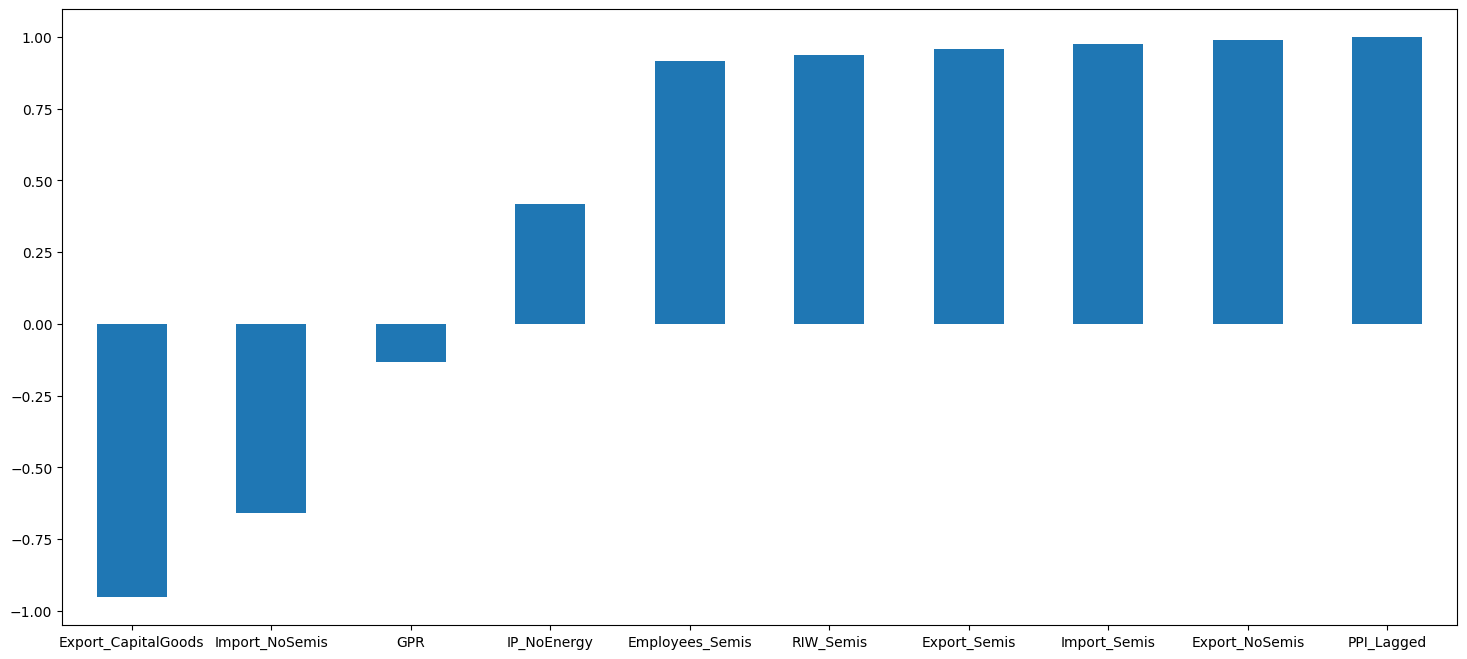

In [20]:
plt.figure(figsize=(18,8))
df.corr()['PPI'].drop('PPI').sort_values().plot(kind='bar')
plt.xticks(rotation='horizontal')

In [21]:
cdf_3M = df[['PPI','PPI_Lagged','Import_Semis','GPR']]
cdf_3M.tail(5)

,PPI,PPI_Lagged,Import_Semis,GPR
342,4.039924,4.041576,4.122284,4.904500
343,4.048527,4.039607,4.119037,4.779006
344,4.052446,4.036574,4.115780,4.905679
345,4.053141,4.039924,4.115780,4.897674
346,4.045749,4.048527,4.120662,4.982745


In [22]:
# Split the data into a % training set and % test set
train_size = 0.8
train_idx = int(train_size * len(cdf_3M))
train_data = cdf_3M.iloc[:train_idx]
test_data = cdf_3M.iloc[train_idx:]

# Split the training and test data into features and target variables
X_train = train_data.drop(columns=['PPI']).values
y_train = train_data['PPI'].values
X_test = test_data.drop(columns=['PPI']).values
y_test = test_data['PPI'].values

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize best R2 score to a very small value
best_r2_score = -float('inf')
best_y_pred = -float('inf')
# Try different values of n_estimators
n_estimators_list = [10, 50, 100, 200, 500]

# Train random forest regression model
for n_estimators in n_estimators_list:
  rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  rf.fit(X_train, y_train)
  # Make predictions on test set
  y_pred = rf.predict(X_test)

  # Calculate evaluation metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Check if current R2 score is better than the best so far
  if r2 > best_r2_score:
      best_r2_score = r2
      best_mae = mae
      best_mse = mse
      best_n_estimators = n_estimators
      best_y_pred = y_pred

  # Print evaluation metrics
  print(f'Random Forest with {n_estimators} estimators')
  print('Random Forest MAE:', mae)
  print('Random Forest MSE:', mse)
  print('Random Forest R2 score:', r2)
  print('\n')


# Print the results with the best R2 score
print(f'Best Random Forest with {best_n_estimators} estimators')
print('Random Forest MAE:',  best_mae)
print('Random Forest MSE:',  best_mse)
print('Random Forest R2 score:', best_r2_score)

rf = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)
rf.fit(X_train, y_train)

Random Forest with 10 estimators
Random Forest MAE: 0.028719445993545773
Random Forest MSE: 0.0010878493253610603
Random Forest R2 score: -2.614497820951129


Random Forest with 50 estimators
Random Forest MAE: 0.029043723149378982
Random Forest MSE: 0.0011128973778222531
Random Forest R2 score: -2.6977227023105055


Random Forest with 100 estimators
Random Forest MAE: 0.029042279628147254
Random Forest MSE: 0.0011130705496273639
Random Forest R2 score: -2.6982980844867224


Random Forest with 200 estimators
Random Forest MAE: 0.028970128785631755
Random Forest MSE: 0.0011087607931060989
Random Forest R2 score: -2.683978449228621


Random Forest with 500 estimators
Random Forest MAE: 0.02900126112840935
Random Forest MSE: 0.001111531049473053
Random Forest R2 score: -2.6931829276139974


Best Random Forest with 10 estimators
Random Forest MAE: 0.028719445993545773
Random Forest MSE: 0.0010878493253610603
Random Forest R2 score: -2.614497820951129


RandomForestRegressor(n_estimators=10, random_state=42)

In [24]:
train_y_pred = rf.predict(X_train)
train_mape = np.mean(np.abs((y_train - train_y_pred) / y_train)) * 100
print("Train MAPE: {:.8f}%".format(train_mape))

# test_mape = np.mean(np.abs((result_df['true'] - result_df['svr_predicted']) / result_df['true'])) * 100
test_mape = np.mean(np.abs((y_test-best_y_pred) / y_test)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.05554578%
Test MAPE: 0.71625354%


In [25]:
train_actual = train_data.reset_index(drop=True)
train_pred = pd.DataFrame(rf.predict(X_train), columns=['PPI_pred'])

# Create dataframes for actual and predicted values of test set
test_actual = test_data.reset_index(drop=True)
test_pred = pd.DataFrame(best_y_pred, columns=['PPI_pred'])

# Concatenate actual and predicted values for train and test sets
train_df = pd.concat([train_actual, train_pred], axis=1)
test_df = pd.concat([test_actual, test_pred], axis=1)

# Calculate MAPE for train and test sets separately
train_df['MAPE'] = np.abs(train_df['PPI'] - train_df['PPI_pred']) / train_df['PPI']
test_df['MAPE'] = np.abs(test_df['PPI'] - test_df['PPI_pred']) / test_df['PPI']

# Print train and test MAPE results
print("Train MAPE: {:.8%}".format(train_df['MAPE'].mean()))
print("Test MAPE: {:.8%}".format(test_df['MAPE'].mean()))

Train MAPE: 0.05554578%
Test MAPE: 0.71625354%


In [26]:
# y_train_pred = rf.predict(X_train)
# y_test_pred = rf.predict(X_test)
# # Plot train and test performance
# plt.plot(y_train, label='Train')
# plt.plot(y_train_pred, label='Train Predicted')
# plt.plot(y_test, label='Test')
# plt.plot(y_test_pred, label='Test Predicted')
# plt.legend()
# plt.show()

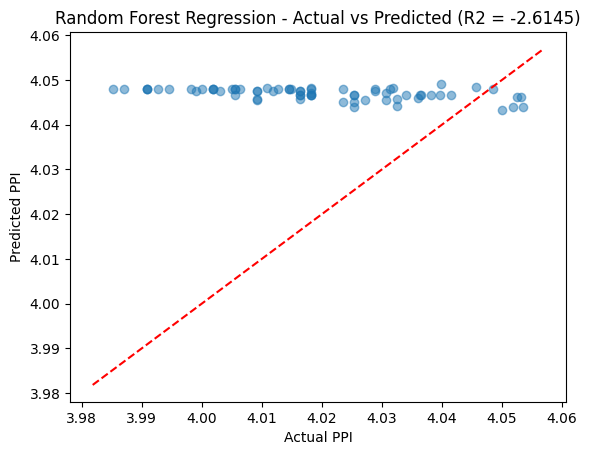

In [27]:
import matplotlib.pyplot as plt

# Scatter plot of predicted vs actual values
plt.scatter(y_test, best_y_pred, alpha=0.5)
plt.title(f'Random Forest Regression - Actual vs Predicted (R2 = {best_r2_score:.4f})')
plt.xlabel('Actual PPI')
plt.ylabel('Predicted PPI')
x_line = y_line = plt.xlim()
plt.plot(x_line, y_line, color='red', linestyle='--')
plt.show()

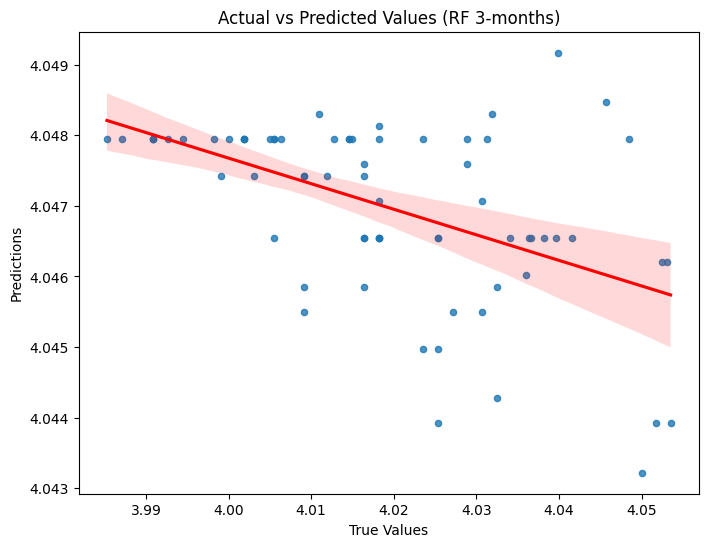

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot actual vs predicted values
sns.regplot(x=y_test, y=best_y_pred, scatter_kws={"s": 20}, line_kws={"color": "red"})
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Actual vs Predicted Values (RF 3-months)")
plt.show()

In [29]:
# CODE WORKING NEED TO PLACE THE RIGHT FEATURES ON THE CDF TABLE
# # define the predictor variables for the forecast
# X_pred = cdf_3M[['PPI_Lagged','Export_NoSemis', 'RIW_Semis']].tail(3)

# # predict the target variable for the next month
# y_pred = rf.predict(X_pred)

# # create a new DataFrame for the predicted values
# forecast_df = pd.DataFrame(data=y_pred, columns=['PPI'])

# # set the index to the next 3 month(s)
# forecast_df = pd.DataFrame({'Forecasted PPI': y_pred}, index=pd.date_range(start=cdf_3M.index[-1], periods=3, freq='MS'))

# # plot the actual and forecasted values
# plt.plot(range(len(cdf_3M)), cdf_3M['PPI'], label='Historical PPI')
# plt.plot(range(len(cdf_3M),len(cdf_3M)+3), forecast_df['Forecasted PPI'], label='Forecasted PPI')
# plt.xlabel('Time (months)')
# plt.ylabel('PPI')
# plt.title('SVR Historical and Forecasted PPI')
# plt.legend()
# plt.show()
# print("Forecasted PPI for the next 3 month(s):", forecast_df.values)

**Forecast for 6 month(s)**

In [30]:
df = pd.read_excel("/content/drive/MyDrive/MBA/DataTables_Semis-Forecasting/DataTable_Semis-Forecasting-6M.xlsx")

In [31]:
df.tail(5)

,Date,PPI,PPI_Lagged,GPR,Export_Semis,Import_Semis,Employees_Semis,Export_NoSemis,Import_NoSemis,RIW_Semis,Export_CapitalGoods,IP_NoEnergy
339,2022-09-01,4.039924,4.038233,5.785128,4.119037,4.085976,5.938327,3.848018,4.790820,0.342738,4.969813,4.614697
340,2022-10-01,4.048527,4.034028,5.271923,4.123903,4.096010,5.945159,3.862833,4.794964,0.292296,4.976044,4.618786
341,2022-11-01,4.052446,4.036433,4.974446,4.120662,4.109233,5.951423,3.862833,4.797442,0.274445,4.978801,4.614332
342,2022-12-01,4.053141,4.041576,4.904500,4.117410,4.122284,5.956614,3.860730,4.797442,0.274445,4.980176,4.606434
343,2023-01-01,4.045749,4.039607,4.779006,4.117410,4.119037,5.963579,3.856510,4.799914,0.258511,4.987025,4.608073


In [32]:
df.columns

Index(['Date', 'PPI', 'PPI_Lagged', 'GPR', 'Export_Semis', 'Import_Semis',
       'Employees_Semis', 'Export_NoSemis', 'Import_NoSemis', 'RIW_Semis',
       'Export_CapitalGoods', 'IP_NoEnergy'],
      dtype='object')

<ipython-input-33-af785ddfd842>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['PPI'].drop('PPI').sort_values().plot(kind='bar')


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Export_CapitalGoods'),
  Text(1, 0, 'Import_NoSemis'),
  Text(2, 0, 'GPR'),
  Text(3, 0, 'IP_NoEnergy'),
  Text(4, 0, 'Employees_Semis'),
  Text(5, 0, 'RIW_Semis'),
  Text(6, 0, 'Export_Semis'),
  Text(7, 0, 'Import_Semis'),
  Text(8, 0, 'Export_NoSemis'),
  Text(9, 0, 'PPI_Lagged')])

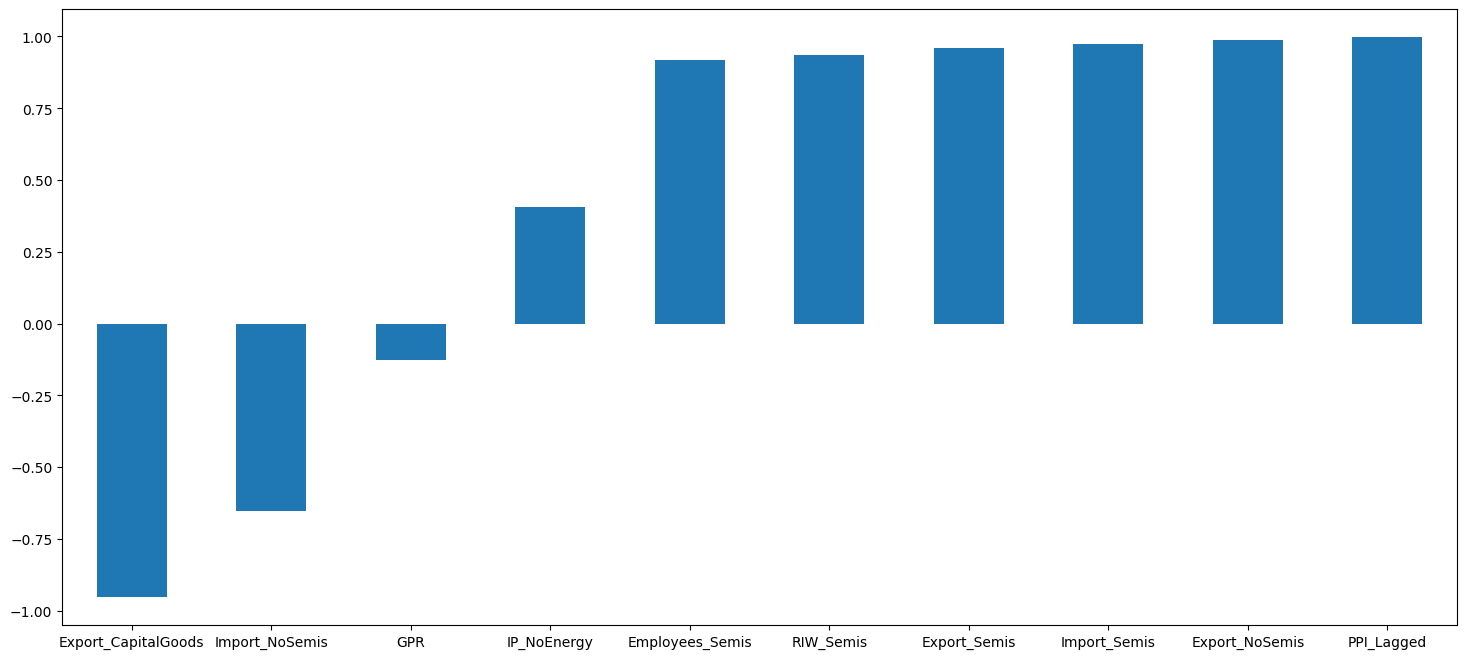

In [33]:
plt.figure(figsize=(18,8))
df.corr()['PPI'].drop('PPI').sort_values().plot(kind='bar')
plt.xticks(rotation='horizontal')

In [34]:
cdf_6M = df[['PPI', 'PPI_Lagged','Import_Semis', 'GPR', 'Export_Semis']]
cdf_6M.tail(5)

,PPI,PPI_Lagged,Import_Semis,GPR,Export_Semis
339,4.039924,4.038233,4.085976,5.785128,4.119037
340,4.048527,4.034028,4.096010,5.271923,4.123903
341,4.052446,4.036433,4.109233,4.974446,4.120662
342,4.053141,4.041576,4.122284,4.904500,4.117410
343,4.045749,4.039607,4.119037,4.779006,4.117410


In [35]:
# Split the data into a % training set and % test set
train_size = 0.8
train_idx = int(train_size * len(cdf_6M))
train_data = cdf_6M.iloc[:train_idx]
test_data = cdf_6M.iloc[train_idx:]

# Split the training and test data into features and target variables
X_train = train_data.drop(columns=['PPI']).values
y_train = train_data['PPI'].values
X_test = test_data.drop(columns=['PPI']).values
y_test = test_data['PPI'].values

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize best R2 score to a very small value
best_r2_score = -float('inf')
best_y_pred = -float('inf')
# Try different values of n_estimators
n_estimators_list = [10, 50, 100, 200, 500]

# Train random forest regression model
for n_estimators in n_estimators_list:
  rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  rf.fit(X_train, y_train)
  # Make predictions on test set
  y_pred = rf.predict(X_test)

  # Calculate evaluation metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Check if current R2 score is better than the best so far
  if r2 > best_r2_score:
      best_r2_score = r2
      best_mae = mae
      best_mse = mse
      best_n_estimators = n_estimators
      best_y_pred = y_pred

  # Print evaluation metrics
  print(f'Random Forest with {n_estimators} estimators')
  print('Random Forest MAE:', mae)
  print('Random Forest MSE:', mse)
  print('Random Forest R2 score:', r2)
  print('\n')


# Print the results with the best R2 score
print(f'Best Random Forest with {best_n_estimators} estimators')
print('Random Forest MAE:',  best_mae)
print('Random Forest MSE:',  best_mse)
print('Random Forest R2 score:', best_r2_score)

Random Forest with 10 estimators
Random Forest MAE: 0.029021178339597074
Random Forest MSE: 0.0010908152855093798
Random Forest R2 score: -2.785530180294988


Random Forest with 50 estimators
Random Forest MAE: 0.030408708852006385
Random Forest MSE: 0.0011846713632905023
Random Forest R2 score: -3.111245285101793


Random Forest with 100 estimators
Random Forest MAE: 0.030219698554166195
Random Forest MSE: 0.0011727916171079113
Random Forest R2 score: -3.0700181971558793


Random Forest with 200 estimators
Random Forest MAE: 0.030285524921313207
Random Forest MSE: 0.0011787161060544202
Random Forest R2 score: -3.0905783524890174


Random Forest with 500 estimators
Random Forest MAE: 0.03021907604431704
Random Forest MSE: 0.0011736876465118316
Random Forest R2 score: -3.073127748695935


Best Random Forest with 10 estimators
Random Forest MAE: 0.029021178339597074
Random Forest MSE: 0.0010908152855093798
Random Forest R2 score: -2.785530180294988


In [37]:
train_y_pred = rf.predict(X_train)
train_mape = np.mean(np.abs((y_train - train_y_pred) / y_train)) * 100
print("Train MAPE: {:.8f}%".format(train_mape))

# test_mape = np.mean(np.abs((result_df['true'] - result_df['svr_predicted']) / result_df['true'])) * 100
test_mape = np.mean(np.abs((y_test-best_y_pred) / y_test)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.04227753%
Test MAPE: 0.72378428%


In [38]:
train_actual = train_data.reset_index(drop=True)
train_pred = pd.DataFrame(rf.predict(X_train), columns=['PPI_pred'])

# Create dataframes for actual and predicted values of test set
test_actual = test_data.reset_index(drop=True)
test_pred = pd.DataFrame(best_y_pred, columns=['PPI_pred'])

# Concatenate actual and predicted values for train and test sets
train_df = pd.concat([train_actual, train_pred], axis=1)
test_df = pd.concat([test_actual, test_pred], axis=1)

# Calculate MAPE for train and test sets separately
train_df['MAPE'] = np.abs(train_df['PPI'] - train_df['PPI_pred']) / train_df['PPI']
test_df['MAPE'] = np.abs(test_df['PPI'] - test_df['PPI_pred']) / test_df['PPI']

# Print train and test MAPE results
print("Train MAPE: {:.8%}".format(train_df['MAPE'].mean()))
print("Test MAPE: {:.8%}".format(test_df['MAPE'].mean()))

Train MAPE: 0.04227753%
Test MAPE: 0.72378428%


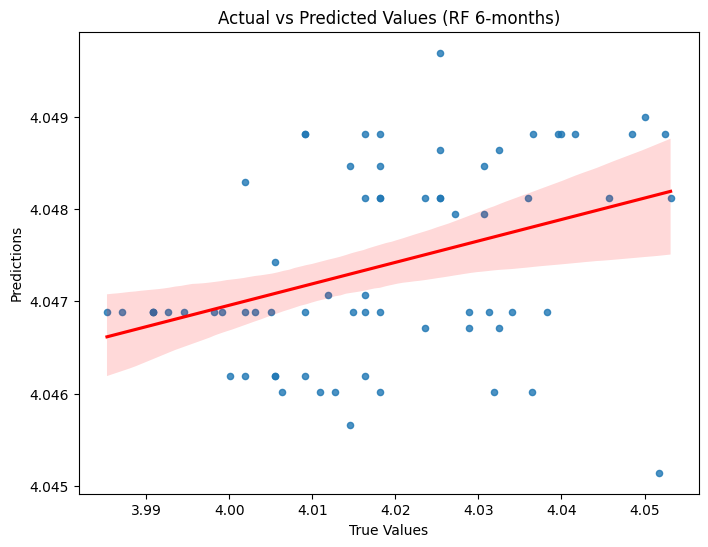

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot actual vs predicted values
sns.regplot(x=y_test, y=best_y_pred, scatter_kws={"s": 20}, line_kws={"color": "red"})
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Actual vs Predicted Values (RF 6-months)")
plt.show()

**Forecasting 12 Months**

In [40]:
df = pd.read_excel("/content/drive/MyDrive/MBA/DataTables_Semis-Forecasting/DataTable_Semis-Forecasting-12M.xlsx")

In [41]:
df.columns

Index(['Date', 'PPI', 'PPI_Lagged', 'GPR', 'Export_Semis', 'Import_Semis',
       'Employees_Semis', 'Export_NoSemis', 'Import_NoSemis', 'RIW_Semis',
       'Export_CapitalGoods', 'IP_NoEnergy'],
      dtype='object')

In [42]:
cdf_12M = df[['PPI',  'Export_Semis', 'Import_Semis']]
cdf_12M.tail(5)

,PPI,Export_Semis,Import_Semis
333,4.039924,4.117410,4.051785
334,4.048527,4.110874,4.055257
335,4.052446,4.109233,4.058717
336,4.053141,4.105944,4.062166
337,4.045749,4.109233,4.072440


In [43]:
# Split the data into a % training set and % test set
train_size = 0.8
train_idx = int(train_size * len(cdf_12M))
train_data = cdf_12M.iloc[:train_idx]
test_data = cdf_12M.iloc[train_idx:]

# Split the training and test data into features and target variables
X_train = train_data.drop(columns=['PPI']).values
y_train = train_data['PPI'].values
X_test = test_data.drop(columns=['PPI']).values
y_test = test_data['PPI'].values

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize best R2 score to a very small value
best_r2_score = -float('inf')
best_y_pred = -float('inf')
# Try different values of n_estimators
n_estimators_list = [10, 50, 100, 200, 500]

# Train random forest regression model
for n_estimators in n_estimators_list:
  rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  rf.fit(X_train, y_train)
  # Make predictions on test set
  y_pred = rf.predict(X_test)

  # Calculate evaluation metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Check if current R2 score is better than the best so far
  if r2 > best_r2_score:
      best_r2_score = r2
      best_mae = mae
      best_mse = mse
      best_n_estimators = n_estimators
      best_y_pred = y_pred

  # Print evaluation metrics
  print(f'Random Forest with {n_estimators} estimators')
  print('Random Forest MAE:', mae)
  print('Random Forest MSE:', mse)
  print('Random Forest R2 score:', r2)
  print('\n')


# Print the results with the best R2 score
print(f'Best Random Forest with {best_n_estimators} estimators')
print('Random Forest MAE:',  best_mae)
print('Random Forest MSE:',  best_mse)
print('Random Forest R2 score:', best_r2_score)

Random Forest with 10 estimators
Random Forest MAE: 0.03011438453160768
Random Forest MSE: 0.0011386121022262544
Random Forest R2 score: -3.122372856970144


Random Forest with 50 estimators
Random Forest MAE: 0.030039366611314254
Random Forest MSE: 0.0011307734031372166
Random Forest R2 score: -3.093992655938182


Random Forest with 100 estimators
Random Forest MAE: 0.029718601422111593
Random Forest MSE: 0.001107278568943385
Random Forest R2 score: -3.008929036317161


Random Forest with 200 estimators
Random Forest MAE: 0.03006324559321744
Random Forest MSE: 0.0011301491268765707
Random Forest R2 score: -3.0917324485268036


Random Forest with 500 estimators
Random Forest MAE: 0.029890956003644168
Random Forest MSE: 0.0011180837276927409
Random Forest R2 score: -3.0480493768233847


Best Random Forest with 100 estimators
Random Forest MAE: 0.029718601422111593
Random Forest MSE: 0.001107278568943385
Random Forest R2 score: -3.008929036317161


In [45]:
train_y_pred = rf.predict(X_train)
train_mape = np.mean(np.abs((y_train - train_y_pred) / y_train)) * 100
print("Train MAPE: {:.8f}%".format(train_mape))

# test_mape = np.mean(np.abs((result_df['true'] - result_df['svr_predicted']) / result_df['true'])) * 100
test_mape = np.mean(np.abs((y_test-best_y_pred) / y_test)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.04198394%
Test MAPE: 0.74110268%


In [46]:
train_y_pred = rf.predict(X_train)
train_mape = np.mean(np.abs((y_train - train_y_pred) / y_train)) * 100
print("Train MAPE: {:.8f}%".format(train_mape))

# test_mape = np.mean(np.abs((result_df['true'] - result_df['svr_predicted']) / result_df['true'])) * 100
test_mape = np.mean(np.abs((y_test-best_y_pred) / y_test)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.04198394%
Test MAPE: 0.74110268%


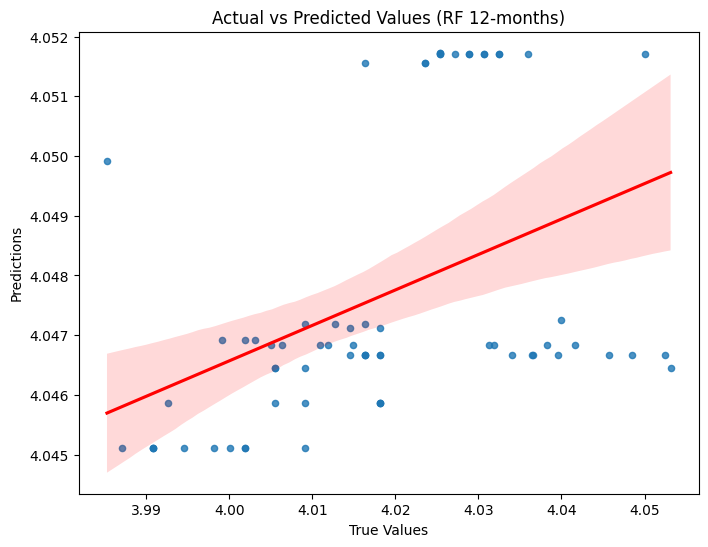

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot actual vs predicted values
sns.regplot(x=y_test, y=best_y_pred, scatter_kws={"s": 20}, line_kws={"color": "red"})
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Actual vs Predicted Values (RF 12-months)")
plt.show()

**Forecasting 24 Months**

In [48]:
df = pd.read_excel("/content/drive/MyDrive/MBA/DataTables_Semis-Forecasting/DataTable_Semis-Forecasting-24M.xlsx")

In [49]:
df.columns

Index(['Date', 'PPI', 'PPI_Lagged', 'GPR', 'Export_Semis', 'Import_Semis',
       'Employees_Semis', 'Export_NoSemis', 'Import_NoSemis', 'RIW_Semis',
       'Export_CapitalGoods', 'IP_NoEnergy'],
      dtype='object')

In [50]:
cdf_24M = df[['PPI', 'Import_Semis','Export_CapitalGoods', 'Import_NoSemis']]
cdf_24M.tail(5)

,PPI,Import_Semis,Export_CapitalGoods,Import_NoSemis
321,4.039924,4.025352,4.916325,4.746670
322,4.048527,4.019980,4.916325,4.748404
323,4.052446,4.019980,4.914858,4.749271
324,4.053141,4.023564,4.916325,4.751001
325,4.045749,4.028917,4.920711,4.753590


In [51]:
# Split the data into a % training set and % test set
train_size = 0.8
train_idx = int(train_size * len(cdf_24M))
train_data = cdf_24M.iloc[:train_idx]
test_data = cdf_24M.iloc[train_idx:]

# Split the training and test data into features and target variables
X_train = train_data.drop(columns=['PPI']).values
y_train = train_data['PPI'].values
X_test = test_data.drop(columns=['PPI']).values
y_test = test_data['PPI'].values

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize best R2 score to a very small value
best_r2_score = -float('inf')
best_y_pred = -float('inf')
# Try different values of n_estimators
n_estimators_list = [10, 50, 100, 200, 500]

# Train random forest regression model
for n_estimators in n_estimators_list:
  rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  rf.fit(X_train, y_train)
  # Make predictions on test set
  y_pred = rf.predict(X_test)

  # Calculate evaluation metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Check if current R2 score is better than the best so far
  if r2 > best_r2_score:
      best_r2_score = r2
      best_mae = mae
      best_mse = mse
      best_n_estimators = n_estimators
      best_y_pred = y_pred

  # Print evaluation metrics
  print(f'Random Forest with {n_estimators} estimators')
  print('Random Forest MAE:', mae)
  print('Random Forest MSE:', mse)
  print('Random Forest R2 score:', r2)
  print('\n')


# Print the results with the best R2 score
print(f'Best Random Forest with {best_n_estimators} estimators')
print('Random Forest MAE:',  best_mae)
print('Random Forest MSE:',  best_mse)
print('Random Forest R2 score:', best_r2_score)

Random Forest with 10 estimators
Random Forest MAE: 0.026567551613856658
Random Forest MSE: 0.0009292810783747162
Random Forest R2 score: -2.518812239701187


Random Forest with 50 estimators
Random Forest MAE: 0.02500332677446515
Random Forest MSE: 0.0008422614460794006
Random Forest R2 score: -2.1893040270185424


Random Forest with 100 estimators
Random Forest MAE: 0.025736769675930627
Random Forest MSE: 0.0008835478087504576
Random Forest R2 score: -2.3456388127797525


Random Forest with 200 estimators
Random Forest MAE: 0.025110629500780392
Random Forest MSE: 0.000847792128367366
Random Forest R2 score: -2.2102464877892154


Random Forest with 500 estimators
Random Forest MAE: 0.02457719622776131
Random Forest MSE: 0.0008179049529466899
Random Forest R2 score: -2.0970758216390926


Best Random Forest with 500 estimators
Random Forest MAE: 0.02457719622776131
Random Forest MSE: 0.0008179049529466899
Random Forest R2 score: -2.0970758216390926


In [53]:
train_y_pred = rf.predict(X_train)
train_mape = np.mean(np.abs((y_train - train_y_pred) / y_train)) * 100
print("Train MAPE: {:.8f}%".format(train_mape))

# test_mape = np.mean(np.abs((result_df['true'] - result_df['svr_predicted']) / result_df['true'])) * 100
test_mape = np.mean(np.abs((y_test-best_y_pred) / y_test)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.04112057%
Test MAPE: 0.61318662%


In [54]:
train_y_pred = rf.predict(X_train)
train_mape = np.mean(np.abs((y_train - train_y_pred) / y_train)) * 100
print("Train MAPE: {:.8f}%".format(train_mape))

# test_mape = np.mean(np.abs((result_df['true'] - result_df['svr_predicted']) / result_df['true'])) * 100
test_mape = np.mean(np.abs((y_test-best_y_pred) / y_test)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.04112057%
Test MAPE: 0.61318662%


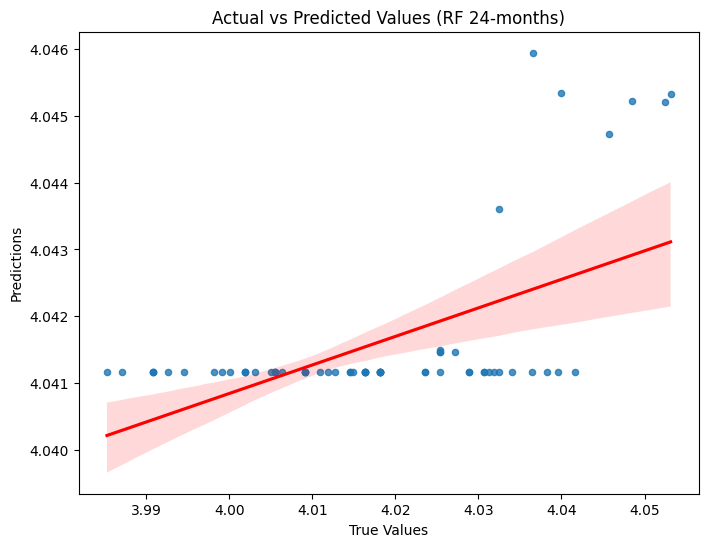

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot actual vs predicted values
sns.regplot(x=y_test, y=best_y_pred, scatter_kws={"s": 20}, line_kws={"color": "red"})
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Actual vs Predicted Values (RF 24-months)")
plt.show()